In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install lightgbm
#!{sys.executable} -m pip install catboost


In [2]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

import ast
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os

random_seed = 347

In [3]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [4]:
## load data
train = pd.read_csv('data/prediction/train.csv')
test = pd.read_csv('data/prediction/test.csv')
# train.index = train['id']
# test.index = test['id']

print("Dimension of train : " + str(train.shape) + " || Dimension of test : " + str(test.shape))
print(train.head())

Dimension of train : (3000, 23) || Dimension of test : (4398, 22)
   id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                NaN   3300000   
3   4                                                NaN   1200000   
4   5                                                NaN         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  

In [5]:
# external data
release_dates = pd.read_csv('data/prediction/release_dates_per_country.csv')
release_dates['id'] = range(1, 7399)
release_dates.drop(['original_title', 'title'], axis=1, inplace=True)
# release_dates.index = release_dates['id']
print(release_dates.head())
print(train.head())
train = pd.merge(train, release_dates, how='left', on=['id'])
test = pd.merge(test, release_dates, how='left', on=['id'])

trainAdditionalFeatures = pd.read_csv('data/prediction/TrainAdditionalFeatures.csv')[
    ['imdb_id', 'popularity2', 'rating']]
testAdditionalFeatures = pd.read_csv('data/prediction/TestAdditionalFeatures.csv')[
    ['imdb_id', 'popularity2', 'rating']]

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])

print(train.head())


   release_year  movie_id  theatrical  theatrical_limited   IT   DE   FR   UA  \
0          2015    243938         6.0                 0.0  1.0  0.0  0.0  0.0   
1          2004     11130        10.0                 0.0  1.0  1.0  1.0  0.0   
2          2014    244786        37.0                 1.0  1.0  1.0  1.0  1.0   
3          2012     82825         3.0                 0.0  0.0  0.0  0.0  0.0   
4          2009     15286         1.0                 0.0  0.0  0.0  0.0  0.0   

    LV   US  ...   PL   ID   MX   AT   SI   HU   KW   BG   PE  id  
0  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1  
1  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   2  
2  0.0  1.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   3  
3  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   4  
4  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   5  

[5 rows x 44 columns]
   id                              belongs_to_collection    budget  \
0   1  [{'id

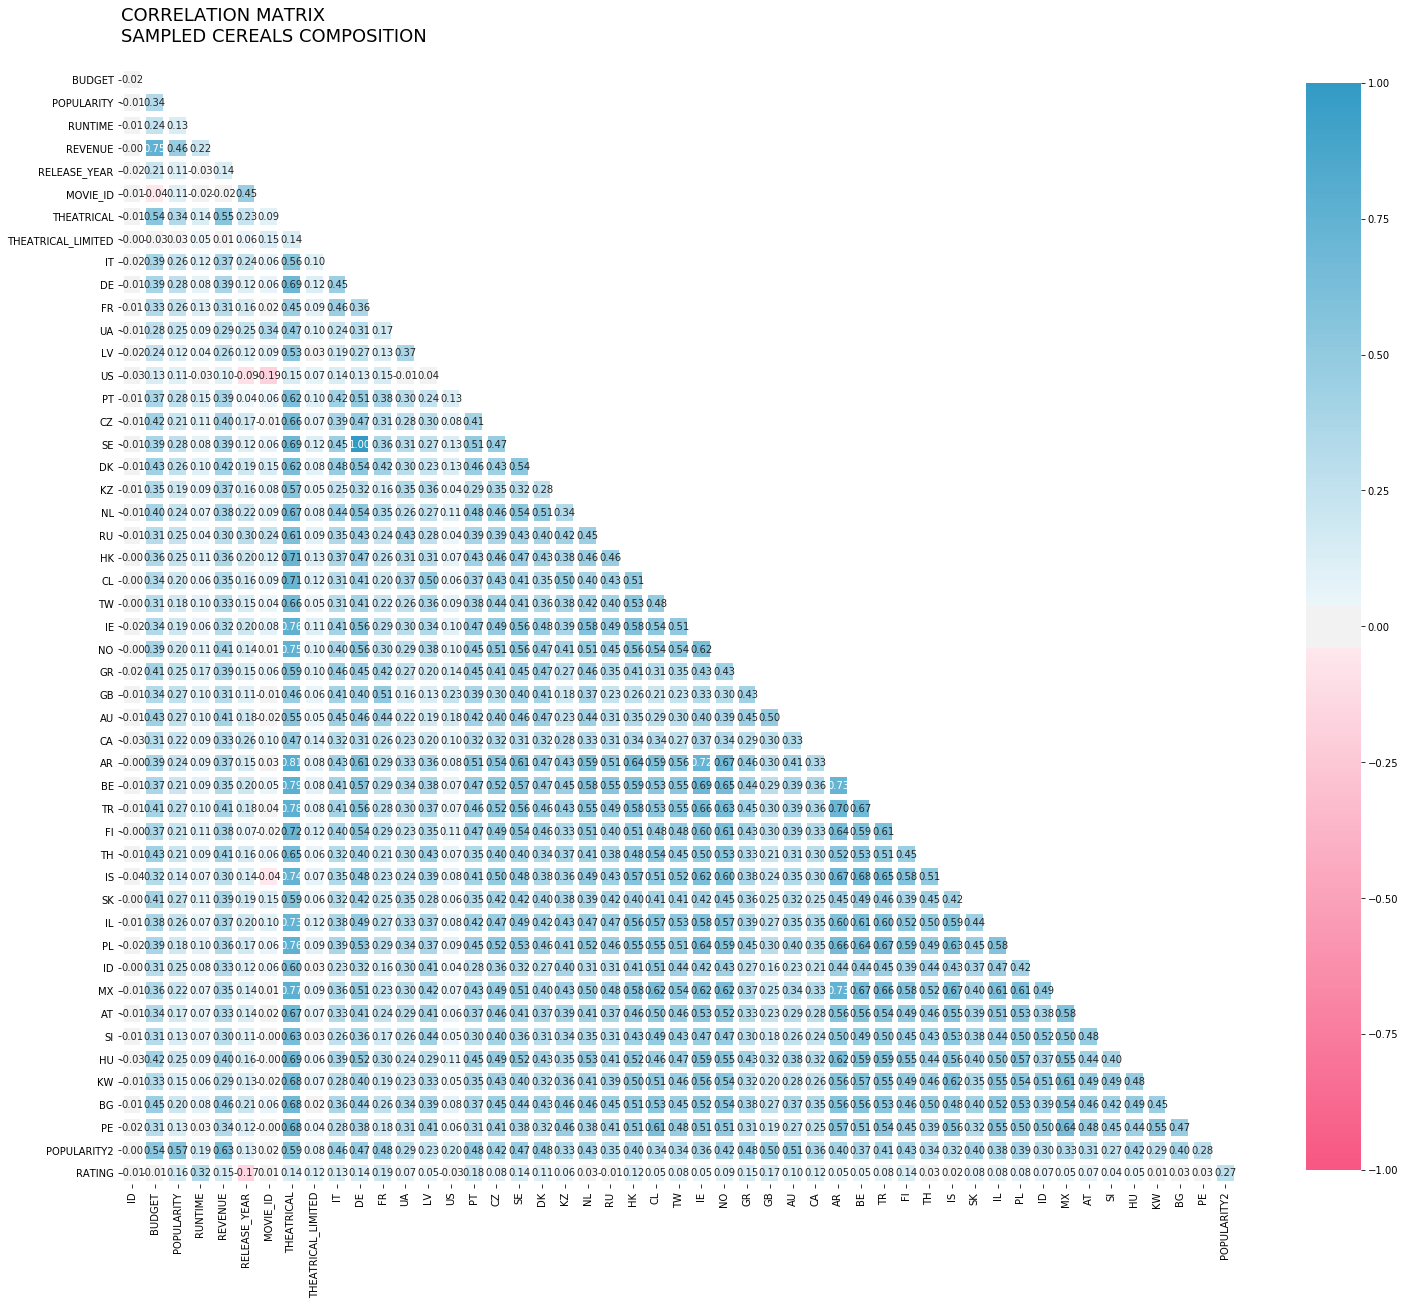

In [6]:
# Calculating correlation
# 1. Budget: 0.75
# 2. popularity2 0.63
# 3. theatrical 0.55

#print(train.corr())
df_corr = train.corr()
fig, ax = plt.subplots(figsize=(25, 25))# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)# title
title = 'CORRELATION MATRIX\nSAMPLED CEREALS COMPOSITION\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

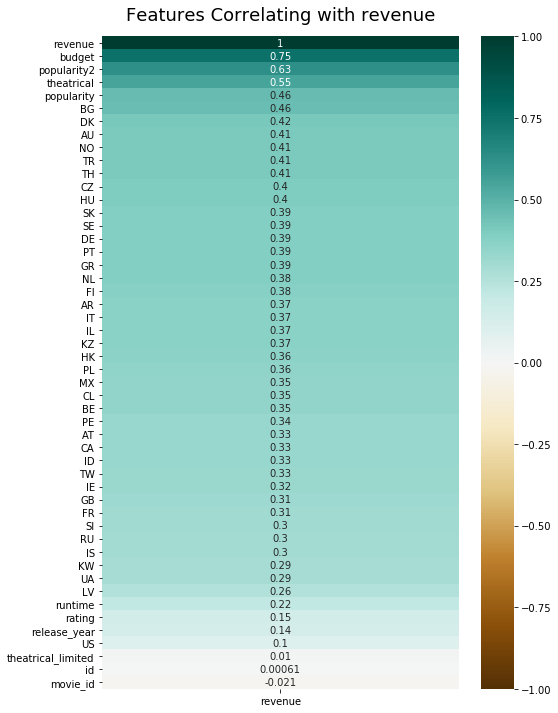

In [7]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_corr[['revenue']].sort_values(by='revenue', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with revenue', fontdict={'fontsize':18}, pad=16);

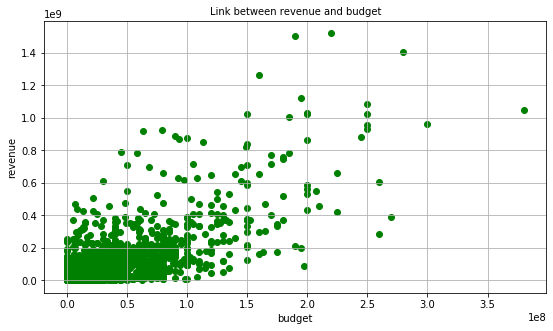

In [8]:
# Revenue with budget

x1 = np.array(train["budget"])
y1 = np.array(train["revenue"])

fig = plt.figure(1, figsize=(9, 5))
plt.scatter(x1, y1, c=['green'], marker='o')
plt.grid()
plt.xlabel("budget", fontsize=10)
plt.ylabel("revenue", fontsize=10)
plt.title("Link between revenue and budget", fontsize=10)
plt.show()

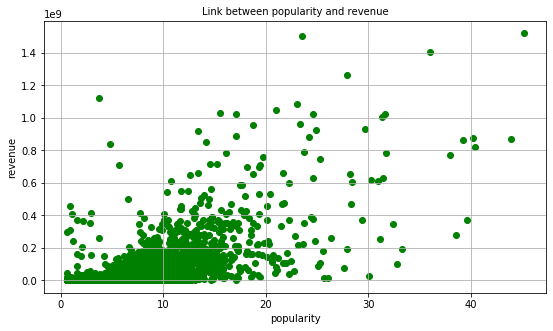

In [9]:
# Revenue with popularity2

x1 = np.array(train["popularity2"])
y1 = np.array(train["revenue"])

fig = plt.figure(1, figsize=(9, 5))
plt.scatter(x1, y1, c=['green'], marker='o')
plt.grid()
plt.xlabel("popularity", fontsize=10)
plt.ylabel("revenue", fontsize=10)
plt.title("Link between popularity and revenue", fontsize=10)
plt.show()

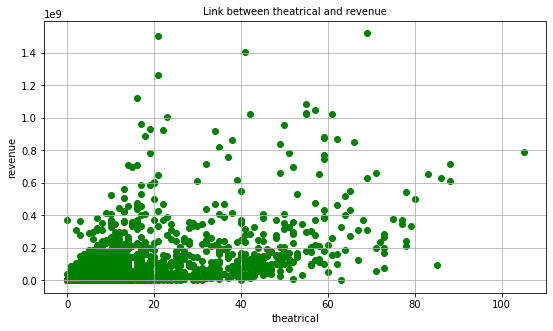

In [10]:
# Revenue with theatrical

x1 = np.array(train["theatrical"])
y1 = np.array(train["revenue"])

fig = plt.figure(1, figsize=(9, 5))

plt.scatter(x1, y1, c=['green'], marker='o')
plt.grid()
plt.xlabel("theatrical", fontsize=10)
plt.ylabel("revenue", fontsize=10)
plt.title("Link between theatrical and revenue", fontsize=10)
plt.show()

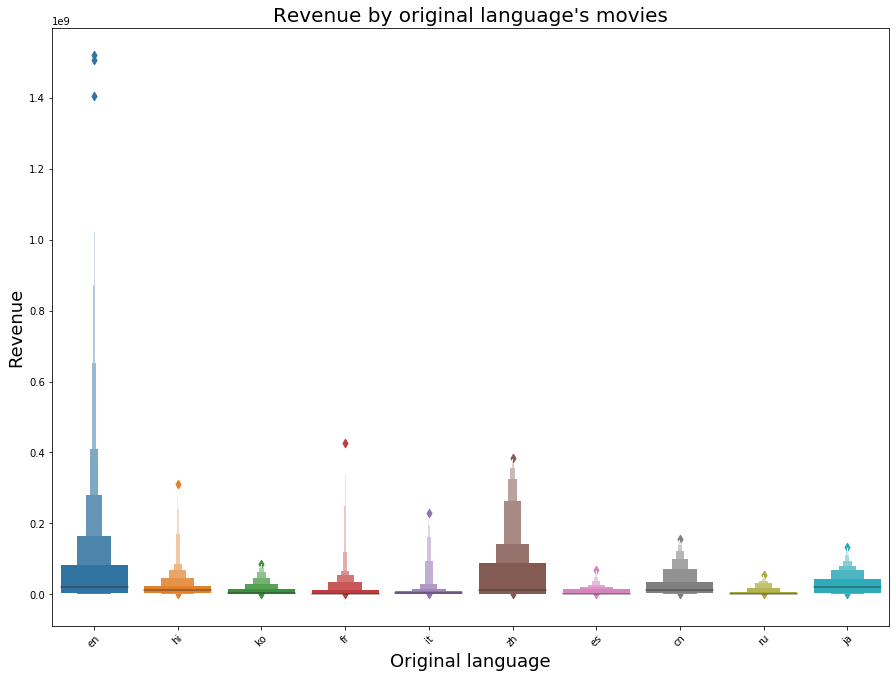

In [11]:
# # Revenue with languages

plt.figure(figsize=(15,11)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.boxenplot(x='original_language', y='revenue',
                   data=train[(train['original_language'].isin((train['original_language'].value_counts()[:10].index.values)))])
g1.set_title("Revenue by original language's movies", fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('Original language', fontsize=18) # Xlabel
g1.set_ylabel('Revenue', fontsize=18) #Ylabel
plt.show()

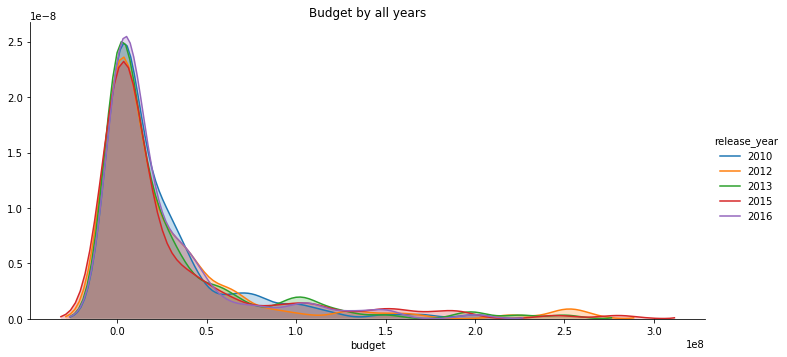

In [12]:
# Budget with release year

#print(train['release_year'].value_counts().index)

(sns.FacetGrid(train[(train['release_year']\
                        .isin(train['release_year']\
                              .value_counts()[:5].index.values))],
               hue='release_year', height=5, aspect=2)
  .map(sns.kdeplot, 'budget', shade=True)
 .add_legend()
)
plt.title("Budget by recent years")
plt.show()

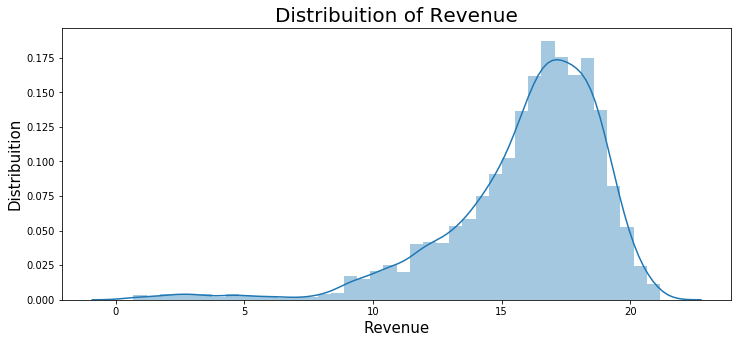

In [13]:
# Revenue with release year

plt.figure(figsize=(12,5))
# Subplot allow us to plot more than one
# in this case, will be create a subplot grid of 2 x 1

# seting the distribuition of our data and normalizing using np.log on values highest than 0 and +
# also, we will set the number of bins and if we want or not kde on our histogram
ax = sns.distplot(np.log1p(train['revenue']), bins=40, kde=True)
ax.set_xlabel('Revenue', fontsize=15) #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize=15) #seting the ylabel and size of font
ax.set_title("Distribuition of Revenue", fontsize=20) #seting the title and size of font
plt.show()

## Prediction

In [29]:
# Processing data

def prepare(df):
    global json_cols
    global train_dict
    
    df['rating'] = df['rating'].fillna(1.5)
    df['totalVotes'] = df['totalVotes'].fillna(6)
    df['weightedRating'] = ( df['rating']*df['totalVotes'] + 6.367 * 1000 ) / ( df['totalVotes'] + 1000 )

    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 18) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 18)  & (df['release_year'] < 100), "release_year"] += 1900
    
    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek 
    df['release_quarter'] = releaseDate.dt.quarter     

    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']

    df['_popularity_totalVotes_ratio'] = df['totalVotes']/df['popularity']
    df['_rating_popularity_ratio'] = df['rating']/df['popularity']
    df['_rating_totalVotes_ratio'] = df['totalVotes']/df['rating']
    df['_totalVotes_releaseYear_ratio'] = df['totalVotes']/df['release_year']
    df['_budget_rating_ratio'] = df['budget']/df['rating']
    df['_runtime_rating_ratio'] = df['runtime']/df['rating']
    df['_budget_totalVotes_ratio'] = df['budget']/df['totalVotes']
    
    df['has_homepage'] = 0
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 1
    
    df['isbelongs_to_collectionNA'] = 0
    df.loc[pd.isnull(df['belongs_to_collection']) ,"isbelongs_to_collectionNA"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    # get collection id
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['cast'].apply(lambda x : len(x))

    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')
    df['meantotalVotesByYear'] = df.groupby("release_year")["totalVotes"].aggregate('mean')
    df['meanTotalVotesByRating'] = df.groupby("rating")["totalVotes"].aggregate('mean')

    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    df = df.drop(['id', 'revenue','belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 

    return df

In [30]:
# Training

train = pd.read_csv('data/prediction/train.csv')
train['revenue'] = np.log1p(train['revenue'])
y = train['revenue'].values

test = pd.read_csv('data/prediction/test.csv')
test['revenue'] = np.nan

release_dates = pd.read_csv('data/prediction/release_dates_per_country.csv')
release_dates['id'] = range(1, 7399)
release_dates.drop(['original_title', 'title'], axis=1, inplace=True)
# release_dates.index = release_dates['id']
print(release_dates.head())
print(train.head())
train = pd.merge(train, release_dates, how='left', on=['id'])
test = pd.merge(test, release_dates, how='left', on=['id'])

# features from https://www.kaggle.com/kamalchhirang/eda-simple-feature-engineering-external-data
train = pd.merge(train, pd.read_csv('data/prediction/TrainAdditionalFeatures.csv'), how='left', on=['imdb_id'])
test = pd.merge(test, pd.read_csv('data/prediction/TestAdditionalFeatures.csv'), how='left', on=['imdb_id'])


json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

for col in tqdm(json_cols + ['belongs_to_collection']) :
    train[col] = train[col].apply(lambda x : get_dictionary(x))
    test[col] = test[col].apply(lambda x : get_dictionary(x))


print(train.shape)
train.head()

  0%|          | 0/8 [00:00<?, ?it/s]

   release_year  movie_id  theatrical  theatrical_limited   IT   DE   FR   UA  \
0          2015    243938         6.0                 0.0  1.0  0.0  0.0  0.0   
1          2004     11130        10.0                 0.0  1.0  1.0  1.0  0.0   
2          2014    244786        37.0                 1.0  1.0  1.0  1.0  1.0   
3          2012     82825         3.0                 0.0  0.0  0.0  0.0  0.0   
4          2009     15286         1.0                 0.0  0.0  0.0  0.0  0.0   

    LV   US  ...   PL   ID   MX   AT   SI   HU   KW   BG   PE  id  
0  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1  
1  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   2  
2  0.0  1.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   3  
3  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   4  
4  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   5  

[5 rows x 44 columns]
   id                              belongs_to_collection    budget  \
0   1  [{'id

100%|██████████| 8/8 [00:04<00:00,  1.74it/s]

(3000, 69)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,MX,AT,SI,HU,KW,BG,PE,popularity2,rating,totalVotes
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.400,5.0,482.0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.229,6.4,1528.0
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.082,8.4,7314.0
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.531,7.5,115.0
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [31]:
# parse json data and build category dictionary
def get_json_dict(df) :
    global json_cols
    result = dict()
    for e_col in json_cols :
        d = dict()
        rows = df[e_col].values
        for row in rows :
            if row is None : continue
            for i in row :
                if i['name'] not in d :
                    d[i['name']] = 0
                d[i['name']] += 1
        result[e_col] = d
    return result

train_dict = get_json_dict(train)
test_dict = get_json_dict(test)

# remove cateogry with bias and low frequency
for col in json_cols :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
            
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]
            
    print(col, 'size :', len(train_id.union(test_id)), '->', len(train_dict[col]))


genres size : 20 -> 19
production_companies size : 7087 -> 77
production_countries size : 98 -> 25
spoken_languages size : 64 -> 27
Keywords size : 11930 -> 358
cast size : 75944 -> 376
crew size : 68763 -> 516


In [32]:
# prepare data
all_data = prepare(pd.concat([train, test]).reset_index(drop = True))
train = all_data.loc[:train.shape[0] - 1,:]
test = all_data.loc[train.shape[0]:,:]       

print(train.shape)
train.head()


(3000, 236)


,budget,popularity,release_year,movie_id,theatrical,theatrical_limited,IT,DE,FR,UA,...,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
0,14000000,6.575393,2015,243938,6.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,40000000,8.248895,2004,11130,10.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,3300000,64.299990,2014,244786,37.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,1200000,3.174936,2012,82825,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.148070,2009,15286,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# K-fold cross validation
from sklearn.model_selection import KFold

random_seed = 2021
k = 5
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(train))
np.random.seed(random_seed)


In [34]:
# Train using XGBoost
import xgboost as xgb

def xgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    params = {'objective': 'reg:linear', 
              'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 
              'seed': random_seed, 
              'silent': True,
    }
    
    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(trn_x, trn_y)
                      , 100000
                      , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks = [xgb.callback.record_evaluation(record)])
    best_idx = np.argmin(np.array(record['valid']['rmse']))

    val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)

    return {'val':val_pred, 'test':test_pred, 'error':record['valid']['rmse'][best_idx], 'importance':[i for k, i in model.get_score().items()]}


In [35]:
# Train using LightGBM
import lightgbm as lgb

def lgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

In [36]:
# Train using CatBoost
from catboost import CatBoostRegressor

def cat_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    model = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = random_seed,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )
    model.fit(trn_x, trn_y,
                 eval_set=(val_x, val_y),
                 use_best_model=True,
                 verbose=False)
    
    val_pred = model.predict(val_x)
    test_pred = model.predict(test)
    
    return {'val':val_pred, 
            'test':test_pred, 
            'error':model.get_best_score()['validation_0']['RMSE']}

In [38]:
result_dict = dict()
val_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
final_err = 0
verbose = False

for i, (trn, val) in enumerate(fold) :
    print(i+1, "fold.    RMSE")
    
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    
    #""" xgboost
    start = datetime.now()
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.2)
    fold_test_pred.append(result['test']*0.2)
    fold_err.append(result['error'])
    print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    #"""
    
    #""" lightgbm
    start = datetime.now()
    result = lgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.4)
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("lgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    #"""
    
    """ catboost model
    start = datetime.now()
    result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.4)
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("cat model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    """
    
    # mix result of multiple models
    val_pred[val] += np.mean(np.array(fold_val_pred), axis = 0)
    #print(fold_test_pred)
    #print(fold_test_pred.shape)
    #print(fold_test_pred.columns)
    test_pred += np.mean(np.array(fold_test_pred), axis = 0) / k
    final_err += (sum(fold_err) / len(fold_err)) / k
    
    print("---------------------------")
    print("avg   err.", "{0:.5f}".format(sum(fold_err) / len(fold_err)))
    print("blend err.", "{0:.5f}".format(np.sqrt(np.mean((np.mean(np.array(fold_val_pred), axis = 0) - val_y)**2))))
    
    print('')
    
print("fianl avg   err.", final_err)
print("fianl blend err.", np.sqrt(np.mean((val_pred - y)**2)))

1 fold.    RMSE
[23:53:33] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:33] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


xgb model. 1.93295 (0m)
lgb model. 1.96606 (0m)
---------------------------
avg   err. 1.94950
blend err. 11.61065

2 fold.    RMSE
[23:53:39] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:39] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please ope